# Urban Air Pollution Challenge

### Can you predict air quality in cities around the world using satellite data?

The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. PM2.5 refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. PM2.5 is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.

In [29]:
#First, our imports

import os
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from scipy.stats import shapiro

from sklearn import set_config
set_config(transform_output='pandas') #we don't need to do set_config if we don't 
                                      #care about our .transform outputting a data frame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
#We have loaded the CSV containing our data in the data folder under "pollution.csv" 
#Below we load it in:

df = pd.read_csv('data/pollution.csv')


In [31]:
#Now we get a very basic preview of it
df.head()

#notice that the place_ID and date appear in individual columns and a combined column
#according to the format of solutions for this task, we must use the column which has them
#combined

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get to know the features

* precipitable_water_entire_atmosphere: The total amount of water vapor in a vertical column of the atmosphere.
* relative_humidity_2m_above_ground: The percentage of water vapor in the air relative to the maximum it can hold at 2 meters above ground level.
* specific_humidity_2m_above_ground: The mass of water vapor per unit mass of air at 2 meters above ground level.
* temperature_2m_above_ground: The air temperature measured 2 meters above the ground.
* u_component_of_wind_10m_above_ground: The east-west (horizontal) component of wind speed at 10 meters above ground level.
* v_component_of_wind_10m_above_ground: The north-south (horizontal) component of wind speed at 10 meters above ground level.
* L3_NO2_NO2_column_number_density: The total vertical column density of nitrogen dioxide (NO₂) in the atmosphere.
* L3_NO2_NO2_slant_column_number_density: The slant column density of nitrogen dioxide (NO₂) measured along the sensor’s line of sight.
* L3_NO2_absorbing_aerosol_index: A measure of the presence of absorbing aerosols like dust and smoke in the atmosphere based on NO₂ data.
* L3_NO2_cloud_fraction: The fraction of the observed area covered by clouds in NO₂ measurements.
* L3_NO2_sensor_altitude: The altitude of the satellite sensor when measuring NO₂.
* L3_NO2_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to NO₂ measurements.
* L3_NO2_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for NO₂ measurements.
* L3_NO2_solar_azimuth_angle: The azimuthal angle of the sun relative to NO₂ measurements.
* L3_NO2_solar_zenith_angle: The angle between the sun's rays and the vertical direction for NO₂ measurements.
* L3_NO2_stratospheric_NO2_column_number_density: The amount of NO₂ in the stratospheric vertical column of the atmosphere.
* L3_NO2_tropopause_pressure: The pressure at the boundary between the troposphere and the stratosphere for NO₂ measurements.
* L3_NO2_tropospheric_NO2_column_number_density: The amount of NO₂ in the tropospheric vertical column of the atmosphere.
* L3_O3_O3_column_number_density: The total vertical column density of ozone (O₃) in the atmosphere.
* L3_O3_O3_effective_temperature: The effective temperature of the ozone layer based on radiative transfer models.
* L3_O3_cloud_fraction: The fraction of the observed area covered by clouds in O₃ measurements.
* L3_O3_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to O₃ measurements.
* L3_O3_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for O₃ measurements.
* L3_O3_solar_azimuth_angle: The azimuthal angle of the sun relative to O₃ measurements.
* L3_O3_solar_zenith_angle: The angle between the sun's rays and the vertical direction for O₃ measurements.
* L3_CO_CO_column_number_density: The total vertical column density of carbon monoxide (CO) in the atmosphere.
* L3_CO_H2O_column_number_density: The total vertical column density of water vapor (H₂O) in the atmosphere based on CO data.
* L3_CO_cloud_height: The height of clouds in CO measurements.
* L3_CO_sensor_altitude: The altitude of the satellite sensor when measuring CO.
* L3_CO_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to CO measurements.
* L3_CO_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for CO measurements.
* L3_CO_solar_azimuth_angle: The azimuthal angle of the sun relative to CO measurements.
* L3_CO_solar_zenith_angle: The angle between the sun's rays and the vertical direction for CO measurements.
* L3_HCHO_HCHO_slant_column_number_density: The slant column density of formaldehyde (HCHO) measured along the sensor’s line of sight.
* L3_HCHO_cloud_fraction: The fraction of the observed area covered by clouds in HCHO measurements.
* L3_HCHO_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to HCHO measurements.
* L3_HCHO_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for HCHO measurements.
* L3_HCHO_solar_azimuth_angle: The azimuthal angle of the sun relative to HCHO measurements.
* L3_HCHO_solar_zenith_angle: The angle between the sun's rays and the vertical direction for HCHO measurements.
* L3_HCHO_tropospheric_HCHO_column_number_density: The amount of HCHO in the tropospheric vertical column of the atmosphere.
* L3_HCHO_tropospheric_HCHO_column_number_density_amf: The air mass factor applied to HCHO tropospheric column density.
* L3_CLOUD_cloud_base_height: The height of the base of clouds.
* L3_CLOUD_cloud_base_pressure: The atmospheric pressure at the base of clouds.
* L3_CLOUD_cloud_fraction: The fraction of the observed area covered by clouds.
* L3_CLOUD_cloud_optical_depth: A measure of the thickness of clouds based on their optical properties.
* L3_CLOUD_cloud_top_height: The height of the top of clouds.
* L3_CLOUD_cloud_top_pressure: The atmospheric pressure at the top of clouds.
* L3_CLOUD_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to cloud measurements.
* L3_CLOUD_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for cloud measurements.
* L3_CLOUD_solar_azimuth_angle: The azimuthal angle of the sun relative to cloud measurements.
* L3_CLOUD_solar_zenith_angle: The angle between the sun's rays and the vertical direction for cloud measurements.
* L3_CLOUD_surface_albedo: The fraction of solar energy reflected by the Earth's surface in cloud measurements.
* L3_AER_AI_absorbing_aerosol_index: A measure of the presence of absorbing aerosols like dust and smoke in the atmosphere.
* L3_AER_AI_sensor_altitude: The altitude of the satellite sensor when measuring aerosols.
* L3_AER_AI_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to aerosol measurements.
* L3_AER_AI_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for aerosol measurements.
* L3_AER_AI_solar_azimuth_angle: The azimuthal angle of the sun relative to aerosol measurements.
* L3_AER_AI_solar_zenith_angle: The angle between the sun's rays and the vertical direction for aerosol measurements.
* L3_SO2_SO2_column_number_density: The total vertical column density of sulfur dioxide (SO₂) in the atmosphere.
* L3_SO2_SO2_column_number_density_amf: The air mass factor applied to SO₂ column density.
* L3_SO2_SO2_slant_column_number_density: The slant column density of SO₂ measured along the sensor’s line of sight.
* L3_SO2_absorbing_aerosol_index: A measure of the presence of absorbing aerosols in the atmosphere based on SO₂ data.
* L3_SO2_cloud_fraction: The fraction of the observed area covered by clouds in SO₂ measurements.
* L3_SO2_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to SO₂ measurements.
* L3_SO2_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for SO₂ measurements.
* L3_SO2_solar_azimuth_angle: The azimuthal angle of the sun relative to SO₂ measurements.
* L3_SO2_solar_zenith_angle: The angle between the sun's rays and the vertical direction for SO₂ measurements.
* L3_CH4_CH4_column_volume_mixing_ratio_dry_air: The volume mixing ratio of methane (CH₄) in dry air.
* L3_CH4_aerosol_height: The height of aerosols in CH₄ measurements.
* L3_CH4_aerosol_optical_depth: A measure of the thickness of aerosols based on their optical properties in CH₄ data.
* L3_CH4_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to CH₄ measurements.
* L3_CH4_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for CH₄ measurements.
* L3_CH4_solar_azimuth_angle: The azimuthal angle of the sun relative to CH₄ measurements.
* L3_CH4_solar_zenith_angle: The angle between the sun's rays and the vertical direction for CH₄ measurements.

## Get to know the target

The target is PM2.5 particle concentration. Recall that ground-based sensors are required in order to measure this. PM2.5 concentration refers to the amount of fine particulate matter in the air with a diameter of 2.5 micrometers or smaller. These tiny particles are generated from sources like vehicle emissions, industrial processes, wildfires, and chemical reactions in the atmosphere. Due to their small size, PM2.5 particles can penetrate deep into the lungs and even enter the bloodstream, posing serious health risks such as respiratory and cardiovascular diseases. PM2.5 is also a significant environmental concern, as it reduces visibility (haze) and contributes to poor air quality. Monitoring and controlling PM2.5 levels are crucial for protecting public health and the environment.


In addition to the target column (which is the daily mean concentration) there are also columns for minimum and maximum readings on that day, the variance of the readings and the total number (count) of sensor readings used to compute the target value. This data is only provided for the train set - we must predict the target variable for the test set


Since we have so many features it would be good to get to know these features first in order to determine which may be irrelevant for our target.


To identify features irrelevant for understanding PM2.5 (fine particulate matter) concentrations, it’s essential to focus on features directly or indirectly related to air quality and pollutant dynamics. Features related to weather, aerosols, and chemical composition of the atmosphere are generally relevant, while those unrelated to these aspects might be less informative.

Here, the unrelated columns are those related to sensor geometry/position and solar geometry so we remove them below. Additionally,

For most studies or analyses of PM2.5 concentrations at ground level:
* Focus on troposphere data as it is directly relevant to the sources, behavior, and health impacts of PM2.5 near the Earth's surface.
* Stratosphere data is generally not necessary for PM2.5 at ground level, unless you're studying specific events like long-range transport of pollutants or examining interactions with ozone, which are typically not the primary concern for ground-level PM2.5.
* So, you should primarily take troposphere data into account and generally ignore stratosphere data for assessing ground-level PM2.5 concentrations.

## Drop Irrelevant Features

In [32]:
#Start by dropping all of the solar, sensor, and stratospheric data, as well as amf which depends on the density feature
#same for slant (TO DO: Write up why we dropped these)
df_cleaned = df[df.columns[~df.columns.str.contains('solar|sensor|stratospheric|amf|slant', case=False)]]

# df.columns.str.contains('solar|sensor', case=False):
# This checks each column name for the substrings 'solar' or 'sensor'.

# The case=False parameter makes the search case-insensitive.
# ~: This negates the result, selecting columns not containing 'solar' or 'sensor'.

# df[df.columns[~...]]: Updates the DataFrame to include only the remaining columns.

In [33]:
#Below we have some more potential redundant features. If our models are performing poorly, we may choose to drop these

# redundant_features = ['L3_HCHO_tropospheric',
#                       'L3_NO2_NO2_slant_column_number_density', 
#                       'L3_HCHO_HCHO_slant_column_number_density',
#                       'L3_SO2_SO2_slant_column_number_density', 
#                       'L3_SO2_cloud_fraction',
#                       'L3_NO2_cloud_fraction',
#                       'L3_O3_cloud_fraction',
#                       'L3_HCHO_cloud_fraction']

In [34]:
df_cleaned['Place_ID X Date'].nunique()
#these are going to be the unique identifiers for our predictions, but they have no bearing on the models
#this means that when we build our models later on, we should ignore this column

30557

In [35]:
print(df_cleaned['Date'].nunique())
print(df_cleaned['Date'].min())
print(df_cleaned['Date'].max())

#It appears that there was a 94 day time span and there were measurements taken on each day

94
2020-01-02
2020-04-04


In [36]:
df_cleaned['Place_ID'].nunique()
#there were a total of 340 places where these measurements were taken

340

In [37]:
#and its shape
df_cleaned.shape

#(30557,46)

(30557, 41)

In [38]:
df_cleaned.info()
#checking data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 41 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  30557 non-null  object 
 1   Date                                             30557 non-null  object 
 2   Place_ID                                         30557 non-null  object 
 3   target                                           30557 non-null  float64
 4   target_min                                       30557 non-null  float64
 5   target_max                                       30557 non-null  float64
 6   target_variance                                  30557 non-null  float64
 7   target_count                                     30557 non-null  int64  
 8   precipitable_water_entire_atmosphere             30557 non-null  float64
 9   relative_humidity_2m_above_g

In [39]:
#Check for rows with missing target values
#Since this is a supervised learning task, we cannot take any rows with missing labels

df_cleaned['target'].isna().sum()

#Great! Nothing missing there

0

## Check feature correlation with target

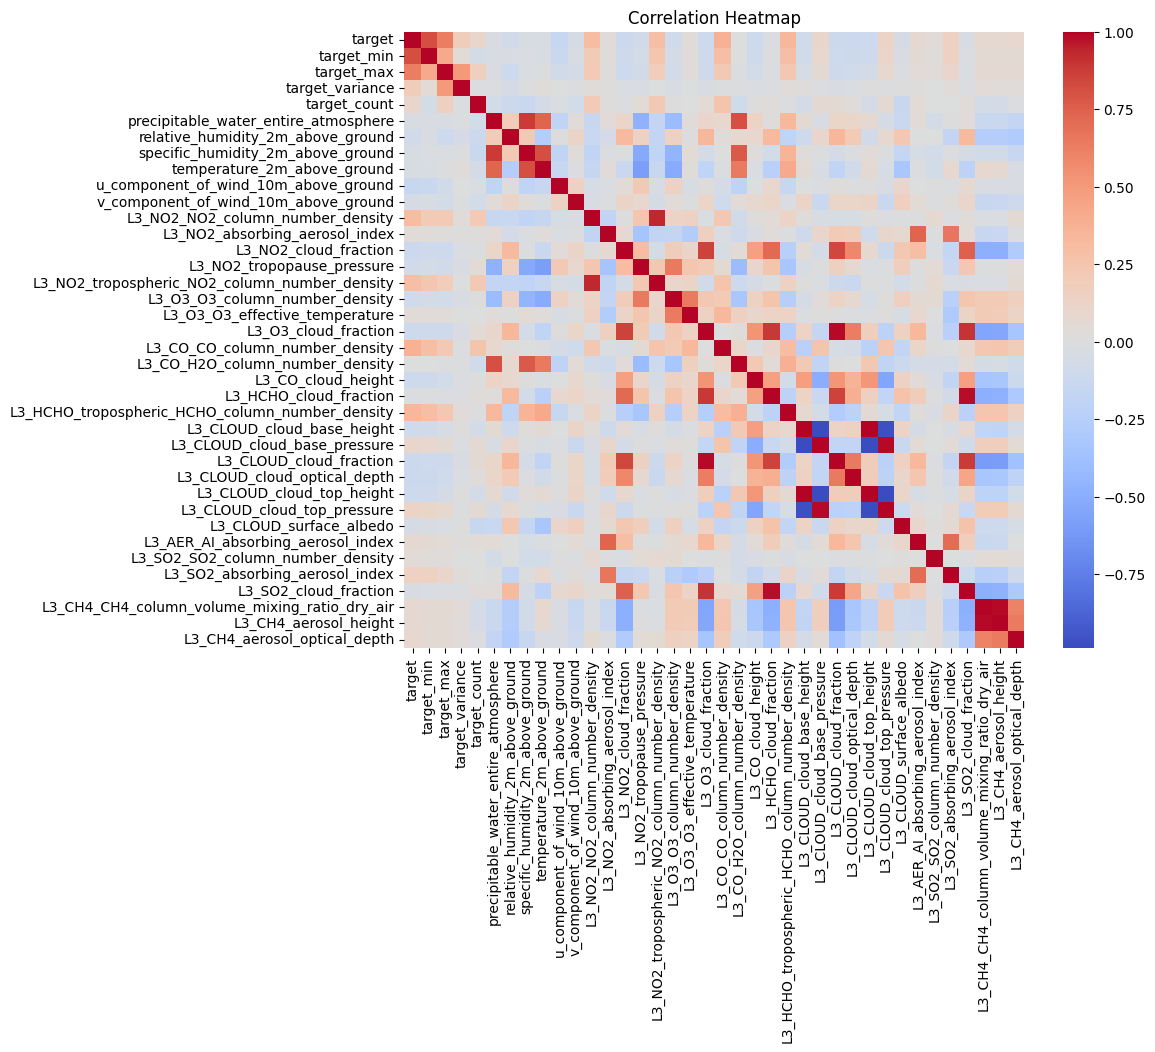

In [40]:
#We also need to remove features which are perfectly correlated with the target
#we need to make sure we are only taking into account the numerical features
df_num = df_cleaned.drop(['Place_ID X Date', 'Date', 'Place_ID'], axis=1)

# Step 1: Compute correlation matrix
correlation_matrix = df_num.corr()

# Correlation with the target column
target_corr = correlation_matrix['target']

# Step 2: Visualize the correlation matrix (if only want to check visually, move to step 4)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We conclude that there is nothing too strongly correlated with the target

### Now check feature correlation with one another

This is a subset of the df_num which doesn't contain the columns containing target information

In [41]:
#Create a data frame where we can evaluate feature correlation
df_num_corr = df_num.dropna()
df_num_corr = df_num_corr.drop(['target','target_min','target_max','target_variance', 'target_count'], axis=1)
df_num_corr

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_tropopause_pressure,...,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_SO2_SO2_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth
1,14.600000,48.799999,0.008390,22.546533,3.330430,-1.188108,0.000076,-1.082553,0.018360,6156.074219,...,175.072145,99353.672374,0.315403,-1.082553,0.000150,-1.452612,0.059433,1789.960449,3384.226562,0.015104
9,10.396144,33.100002,0.005503,22.009790,2.478940,3.750989,0.000072,-0.454374,0.019970,8614.378124,...,4258.137877,60898.927873,0.254715,-0.454373,0.000570,-0.929266,0.058308,0.000000,0.000000,0.000000
10,12.200000,28.000000,0.005020,23.187952,3.180806,0.642266,0.000073,-0.086006,0.022971,8614.380144,...,5890.485352,49212.515625,0.226644,-0.086230,-0.000185,-0.441265,0.004702,0.000000,0.000000,0.000000
12,12.500000,38.000000,0.006834,23.323969,2.782925,1.070105,0.000068,-0.124908,0.020129,7311.869141,...,233.909073,98572.673472,0.304373,-0.124908,-0.000079,-0.314905,0.052229,0.000000,0.000000,0.000000
13,17.700001,36.400002,0.006909,24.122125,4.062515,4.229780,0.000066,-0.049219,0.052600,7311.869141,...,338.357233,97517.707661,0.267974,-0.049217,0.000251,-0.225216,0.123118,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30510,19.269308,85.200005,0.006056,8.793634,3.335283,1.506480,0.000054,-1.220518,0.010042,19125.173162,...,1890.489741,81937.831619,0.098156,-1.220519,0.000484,-1.803997,0.117892,1854.349384,3752.561556,0.018772
30524,8.900001,88.700005,0.004450,3.982599,-1.304509,1.660530,0.000056,-1.075738,0.147451,14418.825417,...,9716.932470,28777.982871,0.250991,-1.075738,0.000220,-2.518281,0.020633,1870.378418,4087.396973,0.034164
30542,7.600000,74.800003,0.003620,3.266931,1.037644,-1.956555,0.000068,-1.336595,0.043963,22046.695887,...,1327.480654,86079.919545,0.149834,-1.336594,0.000564,-1.864423,0.068492,1855.222995,3314.133968,0.022721
30549,18.400000,70.000000,0.005619,10.704462,-1.854288,0.943560,0.000059,-1.503133,0.002353,16676.013652,...,7647.549820,37901.383400,0.226697,-1.503132,0.000509,-2.189909,0.000813,1854.680335,3284.730809,0.012401


We want to do a preliminary check on the correlation between our remaining features.

### Correlation Matrix

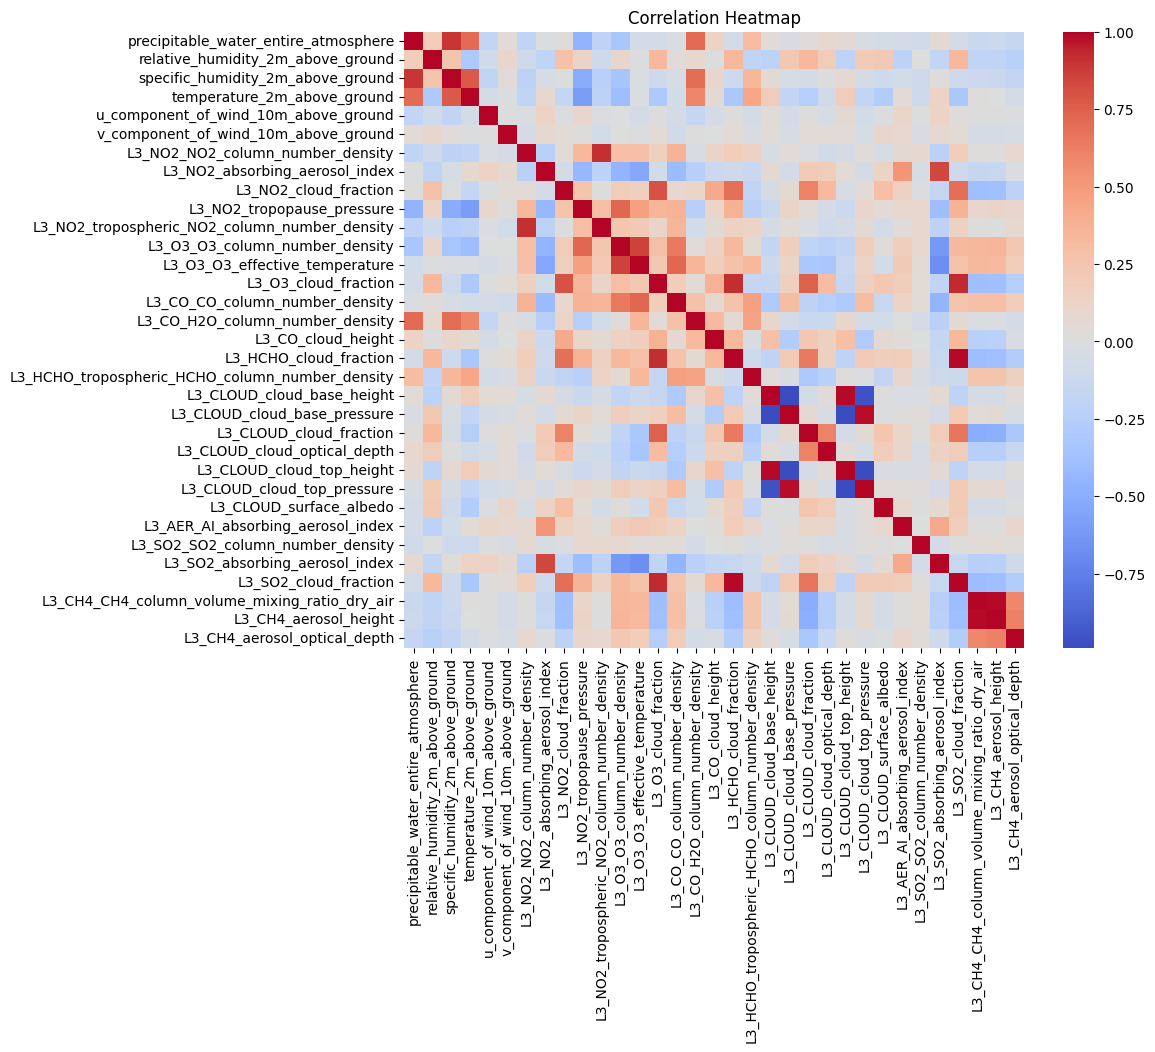

Correlated features (above threshold):


[('L3_NO2_tropospheric_NO2_column_number_density',
  'L3_NO2_NO2_column_number_density'),
 ('L3_HCHO_cloud_fraction', 'L3_O3_cloud_fraction'),
 ('L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_base_height'),
 ('L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_base_height'),
 ('L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_base_pressure'),
 ('L3_CLOUD_cloud_top_pressure', 'L3_CLOUD_cloud_base_height'),
 ('L3_CLOUD_cloud_top_pressure', 'L3_CLOUD_cloud_base_pressure'),
 ('L3_CLOUD_cloud_top_pressure', 'L3_CLOUD_cloud_top_height'),
 ('L3_SO2_cloud_fraction', 'L3_O3_cloud_fraction'),
 ('L3_SO2_cloud_fraction', 'L3_HCHO_cloud_fraction'),
 ('L3_CH4_aerosol_height', 'L3_CH4_CH4_column_volume_mixing_ratio_dry_air')]

In [42]:
#using df_num from above 

feature_corr_matrix = df_num_corr.corr()

#If desired, can plot this matrix with the code below:
plt.figure(figsize=(10, 8))
sns.heatmap(feature_corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


# Set correlation threshold (here there are a lot of features related to one another. 
#This is ok, but we want to take out the ones that are perfectly correlated)
threshold = 0.9

# Find pairs of features with correlation above the threshold
correlated_features = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i):
        if abs(feature_corr_matrix.iloc[i, j]) > threshold:
            correlated_features.append((feature_corr_matrix.index[i], feature_corr_matrix.columns[j]))

# Display the list of correlated feature pairs
print("Correlated features (above threshold):")
correlated_features

Some features are strongly correlated with one another. We will make a list of the final ones we want to drop and then proceed by dropping them

In [43]:
final_drop = ['L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_top_height', 
              'L3_CLOUD_cloud_top_pressure', 'L3_HCHO_cloud_fraction',
              'L3_SO2_cloud_fraction',  'L3_NO2_cloud_fraction', 'L3_O3_cloud_fraction',
              'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature', 
              'L3_CH4_aerosol_optical_depth', 'L3_CH4_aerosol_height', 
              'L3_CH4_CH4_column_volume_mixing_ratio_dry_air']

df_num_final = df_num.drop(columns=final_drop)

In [44]:
#Save metadata of things we're not taking into account

# Identify columns containing specific substrings
pattern_columns = df.columns[df.columns.str.contains('solar|sensor|stratospheric', case=False)]

# Explicitly include specific columns
explicit_columns = ['Place_ID X Date', 'Date', 'Place_ID', 'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_top_height', 
              'L3_CLOUD_cloud_top_pressure', 'L3_HCHO_cloud_fraction',
              'L3_SO2_cloud_fraction', 'L3_NO2_cloud_fraction', 'L3_O3_cloud_fraction', 'L3_O3_O3_column_number_density', 
              'L3_O3_O3_effective_temperature','L3_CH4_aerosol_optical_depth', 'L3_CH4_aerosol_height', 
              'L3_CH4_CH4_column_volume_mixing_ratio_dry_air']

# Combine both sets of columns, ensuring no duplicates
metadata_columns = list(set(pattern_columns).union(explicit_columns))

# Create the metadata DataFrame
metadata = df[metadata_columns]

In [45]:
df_num_final

,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,...,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_HCHO_tropospheric_HCHO_column_number_density,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_SO2_SO2_column_number_density,L3_SO2_absorbing_aerosol_index
0,38.0,23.0,53.0,769.50,92,11.000000,60.200001,0.00804,18.516840,1.996377,...,883.332451,267.017184,0.000064,NaN,0.000000,NaN,NaN,-1.231330,-0.000127,-1.861476
1,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,0.00839,22.546533,3.330430,...,1148.985447,61.216687,0.000171,99354.162958,0.059358,5.958538,0.315403,-1.082553,0.000150,-1.452612
2,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,0.00750,27.031030,5.065727,...,1109.347101,134.700335,0.000124,98118.935248,0.082247,5.755760,0.307463,-1.001241,0.000150,-1.572950
3,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,0.00391,23.971857,3.004001,...,1061.570832,474.821444,0.000081,97258.462755,0.121555,6.246885,0.279637,-0.777023,0.000227,-1.239317
4,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,0.00535,16.816309,2.621787,...,1044.247425,926.926310,0.000140,59875.027957,0.037008,4.205691,0.238241,0.366324,0.000390,0.202489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30552,22.0,14.0,83.0,3848.86,72,6.700000,68.300003,0.00352,4.256799,-4.810586,...,148.082862,192.388239,0.000024,98145.783526,0.001238,5.875377,0.243682,-1.412609,0.000312,-1.953480
30553,53.0,30.0,146.0,9823.87,72,6.300000,77.700005,0.00341,2.067438,-2.346421,...,308.441747,61.379434,-0.000014,96883.197984,0.007750,5.068010,0.156944,-1.448509,0.000362,-2.178236
30554,85.0,52.0,153.0,8900.85,72,7.100000,68.500000,0.00356,4.438623,0.095703,...,673.059505,1572.596434,0.000094,37718.504795,0.026480,10.443789,0.211473,-1.722478,0.000107,-2.365827
30555,103.0,33.0,149.0,13963.90,72,19.100000,66.300003,0.00523,10.573236,0.434940,...,957.667555,846.961465,0.000063,93485.065056,0.175418,9.744343,0.221439,-2.042785,0.000014,-2.784346


## Check the distribution of the target variable

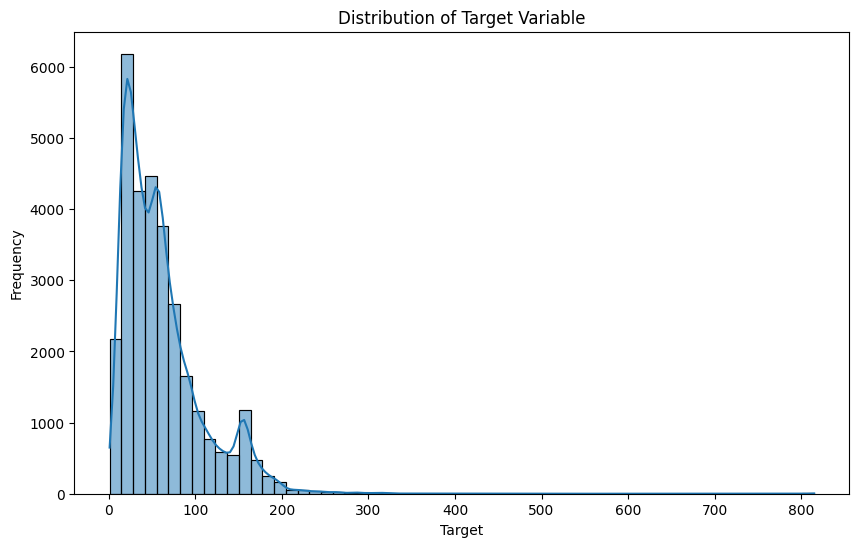

In [46]:
#Step 1: Visualize the target variable. If we only want to check visually, move to step 3
plt.figure(figsize=(10, 6))
sns.histplot(df_num_final['target'], kde=True, bins=60)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

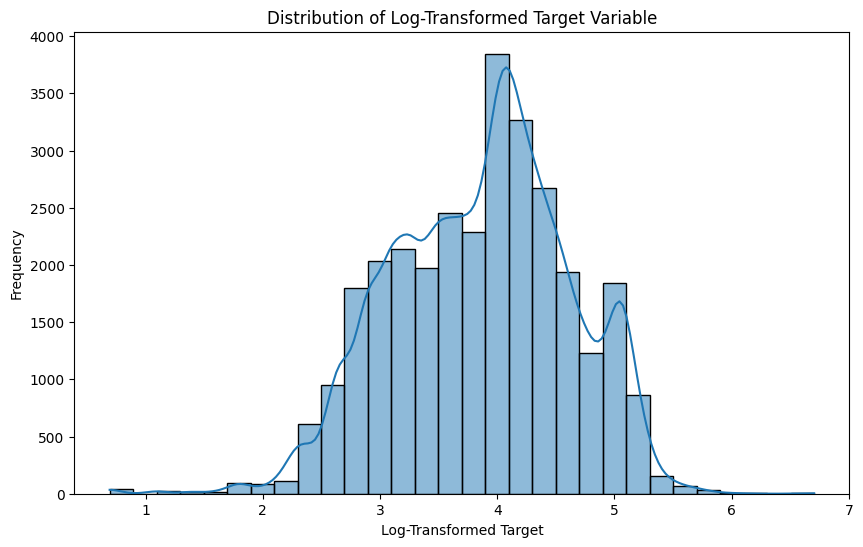

In [47]:
#Normalize the target variable (if not Gaussian)

# Apply log transformation (here use log1p since it is able to 
# handle 0 values, (computes log(1+x))):
df_num_final['target_transformed'] = np.log1p(df_num_final['target'])

#Visualize the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_num_final['target_transformed'], kde=True, bins=30)
plt.title('Distribution of Log-Transformed Target Variable')
plt.xlabel('Log-Transformed Target')
plt.ylabel('Frequency')
plt.show()

In [48]:
df_transformed = df_num_final.drop(['target_min','target', 'target_max','target_variance','target_count'], axis=1)
df_transformed

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,...,L3_CO_cloud_height,L3_HCHO_tropospheric_HCHO_column_number_density,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_SO2_SO2_column_number_density,L3_SO2_absorbing_aerosol_index,target_transformed
0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,-1.231330,6156.074219,0.000017,...,267.017184,0.000064,NaN,0.000000,NaN,NaN,-1.231330,-0.000127,-1.861476,3.663562
1,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,-1.082553,6156.074219,0.000021,...,61.216687,0.000171,99354.162958,0.059358,5.958538,0.315403,-1.082553,0.000150,-1.452612,3.688879
2,16.400000,33.400002,0.00750,27.031030,5.065727,3.500559,0.000067,-1.001242,7311.869141,0.000007,...,134.700335,0.000124,98118.935248,0.082247,5.755760,0.307463,-1.001241,0.000150,-1.572950,3.218876
3,6.911948,21.300001,0.00391,23.971857,3.004001,1.099468,0.000083,-0.777019,11205.388333,0.000023,...,474.821444,0.000081,97258.462755,0.121555,6.246885,0.279637,-0.777023,0.000227,-1.239317,3.912023
4,13.900001,44.700001,0.00535,16.816309,2.621787,2.670559,0.000070,0.366323,11205.372845,0.000009,...,926.926310,0.000140,59875.027957,0.037008,4.205691,0.238241,0.366324,0.000390,0.202489,3.091042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30552,6.700000,68.300003,0.00352,4.256799,-4.810586,-4.195359,0.000063,-1.412609,22073.788216,0.000019,...,192.388239,0.000024,98145.783526,0.001238,5.875377,0.243682,-1.412609,0.000312,-1.953480,3.135494
30553,6.300000,77.700005,0.00341,2.067438,-2.346421,0.749136,0.000072,-1.449760,16689.048841,0.000033,...,61.379434,-0.000014,96883.197984,0.007750,5.068010,0.156944,-1.448509,0.000362,-2.178236,3.988984
30554,7.100000,68.500000,0.00356,4.438623,0.095703,0.141943,0.000068,-1.722480,19245.841946,0.000025,...,1572.596434,0.000094,37718.504795,0.026480,10.443789,0.211473,-1.722478,0.000107,-2.365827,4.454347
30555,19.100000,66.300003,0.00523,10.573236,0.434940,-1.439778,0.000086,-2.065102,16689.689377,0.000038,...,846.961465,0.000063,93485.065056,0.175418,9.744343,0.221439,-2.042785,0.000014,-2.784346,4.644391


## Train-test-split

In [49]:
X = df_transformed.drop(['target_transformed'], axis=1)
y = df_transformed['target_transformed']

#Do the train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Feature Engineering

So far for feature engineering, we have learned a few column transformers:

1. Binning
2. Imputing
3. OneHot Encoding
4. Ordinal Encoding
5. Scaling

To Implement these transformations, we have two tools: Column Transformers and Pipelines:

* **Column Transformers**: allows for application of pipelines & singular tools to multiple columns at once (Note: cannot apply multiple changes to a single column, otherwise it will save multiple versions of the transformed column, each with only a single transformation on them)
* **Pipeline**: applies transformations in a sequence

### Imputing

In [50]:
#First let's check which rows are missing information

X_train.isna().sum().sort_values(ascending=False)

L3_NO2_tropospheric_NO2_column_number_density      6500
L3_HCHO_tropospheric_HCHO_column_number_density    5562
L3_SO2_absorbing_aerosol_index                     5458
L3_SO2_SO2_column_number_density                   5407
L3_CO_cloud_height                                 4056
L3_CO_H2O_column_number_density                    4056
L3_CO_CO_column_number_density                     4056
L3_NO2_absorbing_aerosol_index                     1631
L3_NO2_tropopause_pressure                         1631
L3_NO2_NO2_column_number_density                   1631
L3_CLOUD_cloud_base_pressure                       1147
L3_CLOUD_cloud_optical_depth                       1147
L3_CLOUD_surface_albedo                            1147
L3_CLOUD_cloud_fraction                             283
L3_AER_AI_absorbing_aerosol_index                   146
relative_humidity_2m_above_ground                     0
v_component_of_wind_10m_above_ground                  0
u_component_of_wind_10m_above_ground            

In [51]:
#Almost all of the features are missing something. We want to see what the best imputation values will be for each, so it's a good idea 
#to check the distributions of each of the features with missing values.
#This will help us determine if we should impute with the mean, the median, etc

In [52]:
# Create histograms for each feature to check distribution and see best imputation method

# for col in X_train.columns:
#     plt.figure(figsize=(8, 5))  # Set the figure size
#     X_train[col].hist(bins=30, alpha=0.7, edgecolor='black')  # Create the histogram
#     plt.title(f'Histogram for {col}')  # Add title
#     plt.xlabel(col)  # Label the x-axis
#     plt.ylabel('Frequency')  # Label the y-axis
#     plt.grid(False)  # Optional: Remove the grid for better readability
#     plt.show()  # Display the histogram

### Now scaling

Since some of our columns have outliers, we should use RobustScaler to transform the columns. This is robust to outliers and handles skewed data.
TO DO: Explain scaler choice

In [58]:
#Get our transformations into a nice pipeline
mean_imputer = SimpleImputer(strategy='mean')
mean_column = ['L3_HCHO_tropospheric_HCHO_column_number_density']
median_imputer = SimpleImputer(strategy='median')
median_columns = [col for col in X_train.columns if col != 'L3_HCHO_tropospheric_HCHO_column_number_density']


# Column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('median_impute', median_imputer, median_columns),  # Mean imputation for specific column
        ('mean_impute', mean_imputer, mean_column),      # Median imputation for the rest
    ],
    remainder='passthrough'  # Keep any other columns as is
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('impute', column_transformer),
    ('scale', RobustScaler())  # Apply RobustScaler to all columns
])

X_train_fe = pipeline.fit_transform(X_train)

In [59]:
#Transform X_test
X_test_fe = pipeline.transform(X_test)

## Determine Baseline Model

Our baseline model will be a linear regression

In [60]:
baseline = LinearRegression()
baseline.fit(X_train_fe,y_train)

LinearRegression()

In [63]:
baseline_preds = baseline.predict(X_test_fe)

# Calculate MSE
baseline_mse = mean_squared_error(y_test, baseline_preds)

# Calculate RMSE
baseline_rmse = np.sqrt(baseline_mse)

print(f'The root mean-squared error for the baseline model is {baseline_rmse}')

The root mean-squared error for the baseline model is 0.6441213272663148
